In [3]:
%%writefile main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributed as dist
import torch.multiprocessing as mp

import copy
import random
import time
import os
import urllib.request
import subprocess
import json

from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

# Define constants
SEED = 1234
MODEL_NAME = "LeNet"
SENARIO = "1GPU"
EPOCHS = 10
CLIP = 1.0
teacher_forcing_ratio = 0.5
BATCH_SIZE = 32

ROOT = "./data"  # Root directory for storing datasets and models

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Retry mechanism for downloading files
def download_with_retry(url, filename, retries=5, delay=2):
    for i in range(retries):
        try:
            print(f"Attempt {i+1} to download {url}")
            urllib.request.urlretrieve(url, filename)
            print(f"Successfully downloaded {filename}")
            return
        except urllib.error.URLError as e:
            print(f"Attempt {i+1} failed: {e}")
            time.sleep(delay)
    raise RuntimeError(f"Failed to download {url} after {retries} attempts")

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12345'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x, h

def create_model():
    OUTPUT_DIM = 10
    model = LeNet(OUTPUT_DIM)
    return model

def create_dataloader(rank, world_size, batch_size=BATCH_SIZE, root=ROOT):
    mean = 0.13066048920154572
    std = 0.30810779333114624
    train_transforms = transforms.Compose([
        transforms.RandomRotation(5, fill=(0,)),
        transforms.RandomCrop(28, padding=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])

    outdir = os.path.join(root, 'data')
    if rank == 0 and not os.path.exists(outdir):
        os.makedirs(outdir)

    # Use PyTorch's built-in MNIST dataset to handle downloading
    train_data = datasets.MNIST(root=outdir, train=True, download=True, transform=train_transforms)
    test_data = datasets.MNIST(root=outdir, train=False, download=True, transform=test_transforms)

    VALID_RATIO = 0.9
    n_train_examples = int(len(train_data) * VALID_RATIO)
    n_valid_examples = len(train_data) - n_train_examples

    train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])
    valid_data = copy.deepcopy(valid_data)
    valid_data.dataset.transform = test_transforms

    if rank == 0:
        print(f'Number of training examples: {len(train_data)}')
        print(f'Number of validation examples: {len(valid_data)}')
        print(f'Number of testing examples: {len(test_data)}')

    train_sampler = DistributedSampler(train_data, num_replicas=world_size, rank=rank, shuffle=True)
    val_sampler = DistributedSampler(valid_data, num_replicas=world_size, rank=rank)

    train_dataloader = data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
    val_dataloader = data.DataLoader(valid_data, batch_size=batch_size, sampler=val_sampler, pin_memory=True)
    test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_dataloader, val_dataloader, test_dataloader

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion, rank):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for (x, y) in tqdm(iterator, desc=f"Training on the GPU {rank}", leave=False):
        x = x.to(rank)
        y = y.to(rank)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, rank, mode='Evaluating'):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc=f"{mode} on the GPU {rank}", leave=False):
            x = x.to(rank)
            y = y.to(rank)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Help function to log results
RESULTS_FILE = f"{ROOT}/{MODEL_NAME}_{EPOCHS}epochs_{SENARIO}.json"

def log_results(scenario, results):
    """
    Save results to a JSON file for comparison across scenarios.
    """
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, 'r') as f:
            all_results = json.load(f)
    else:
        all_results = {}

    all_results[scenario] = results

    with open(RESULTS_FILE, 'w') as f:
        json.dump(all_results, f, indent=4)

outdir = f'{ROOT}/model/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

def main_train(rank, world_size, root=outdir, num_epochs=3):
    ## a. Set up the distributed process groups
    setup(rank, world_size)
    print(f"Process {rank} initialized.")

    ## b. Create Model, DataLoader
    model = create_model().to(rank)  # Move model to GPU
    train_dataloader, val_dataloader, test_dataloader = create_dataloader(rank, world_size)

    ## c. Wrap the model with DistributedDataParallel
    ddp_model = DDP(model, device_ids=[rank])

    ## d. Loss and Optimizer
    LR = 5e-4
    criterion = nn.CrossEntropyLoss().to(rank)  # Move loss to GPU
    optimizer = optim.Adam(ddp_model.parameters(), lr=LR)

    ## e. Training Loop
    best_valid_loss = float('inf')
    training_times = []
    train_losses = []
    train_accuracy = []
    validation_times = []
    validation_losses = []
    validation_accuracy = []
    epoch_times = []

    for epoch in trange(num_epochs, desc="Epochs"):
        start_epoch_time = time.monotonic()
        start_time = time.monotonic()

        train_loss, train_acc = train(ddp_model, train_dataloader, optimizer, criterion, rank)
        train_time = time.monotonic() - start_time
        training_times.append(train_time)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        start_time = time.monotonic()
        valid_loss, valid_acc = evaluate(ddp_model, val_dataloader, criterion, rank)
        val_time = time.monotonic() - start_time
        validation_times.append(val_time)
        validation_losses.append(valid_loss)
        validation_accuracy.append(valid_acc)

        CHECKPOINT_PATH = f'{root}tut4-model.pt'
        if rank == 0 and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ddp_model.state_dict(), CHECKPOINT_PATH)

        end_time = time.monotonic()
        e_time = end_time - start_epoch_time
        epoch_times.append(e_time)
        epoch_mins, epoch_secs = epoch_time(start_epoch_time, end_time)

        print(f'--------------|     On process {rank}      |----------------')
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    ## f. Test after train
    map_location = {'cuda:%d' % 0: 'cuda:%d' % rank}
    ddp_model.load_state_dict(
        torch.load(CHECKPOINT_PATH, map_location=map_location, weights_only=True))
    start_time = time.monotonic()
    test_loss, test_acc = evaluate(ddp_model, test_dataloader, criterion, rank)
    test_time = time.monotonic() - start_time
    print(f'Test results on process {rank}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    # Log results
    results = {
        "world_size": world_size,
        "rank": rank,
        "training_times": training_times,
        "train_losses": train_losses,
        "train_accuracy": train_accuracy,
        "validation_times": validation_times,
        "validation_losses": validation_losses,
        "validation_accuracy": validation_accuracy,
        "test_time": test_time,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "epoch_times": epoch_times
    }

    model_name = "LeNet"
    scenario = f"model_{model_name}_epochs{num_epochs}_{world_size}_GPUs_rank{rank}"
    log_results(scenario, results)
    dist.barrier()

    cleanup()
    print(f'Process {rank} finished training.')






if __name__ == "__main__":
    def main():
        world_size = torch.cuda.device_count()
        print(f'Total number of devices detected: {world_size}')

        if world_size > 0:
            if world_size > 1:
                mp.spawn(
                    main_train,
                    args=(world_size,),
                    nprocs=world_size,
                    join=True
                )
            else:
                main_train(rank=0, world_size=1)
        else:
            print('No GPUs found. Please make sure you have configured CUDA correctly.')

    main()

Overwriting main.py


In [4]:
!python main.py

Total number of devices detected: 1
Process 0 initialized.
Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000
Evaluating on the GPU 0:   0%|          | 0/188 [00:00<?, ?it/s]
--------------|     On process 0      |----------------
Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 0.420 | Train Acc: 86.44%
	 Val. Loss: 0.116 |  Val. Acc: 96.18%
Evaluating on the GPU 0:   0%|          | 0/188 [00:00<?, ?it/s]
--------------|     On process 0      |----------------
Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 0.136 | Train Acc: 95.74%
	 Val. Loss: 0.072 |  Val. Acc: 97.69%
Evaluating on the GPU 0:   0%|          | 0/188 [00:00<?, ?it/s]
--------------|     On process 0      |----------------
Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.101 | Train Acc: 96.85%
	 Val. Loss: 0.071 |  Val. Acc: 97.66%
Evaluating on the GPU 0:   0%|          | 0/313 [00:00<?, ?it/s]
Test results on process 0: Test Loss: 0.052 | Test Acc: 98.24%
Process 0 finished

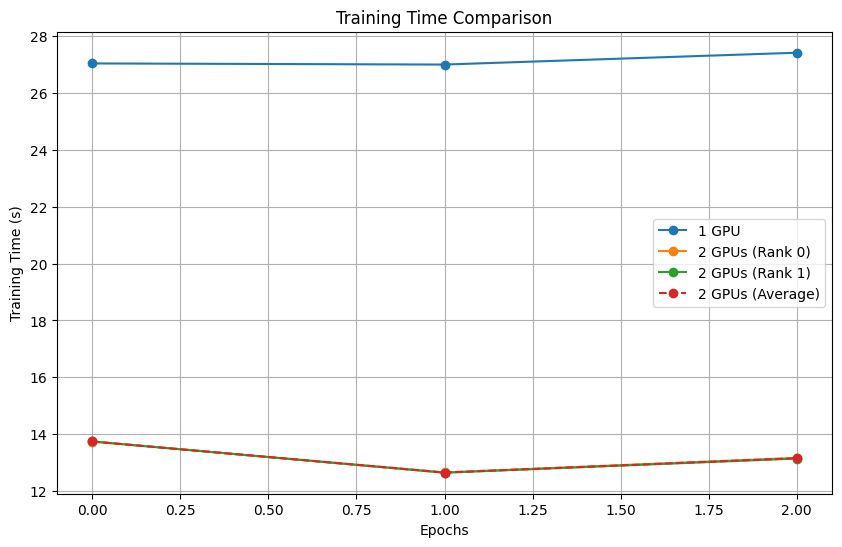

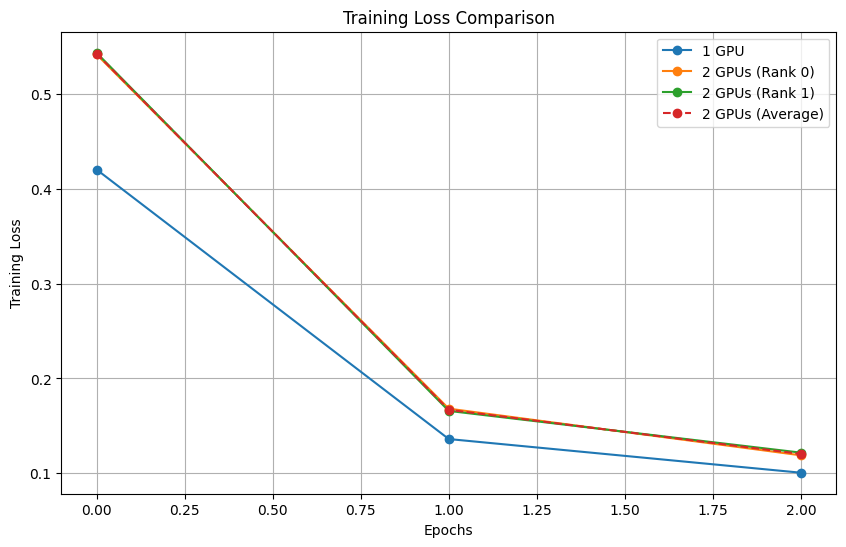

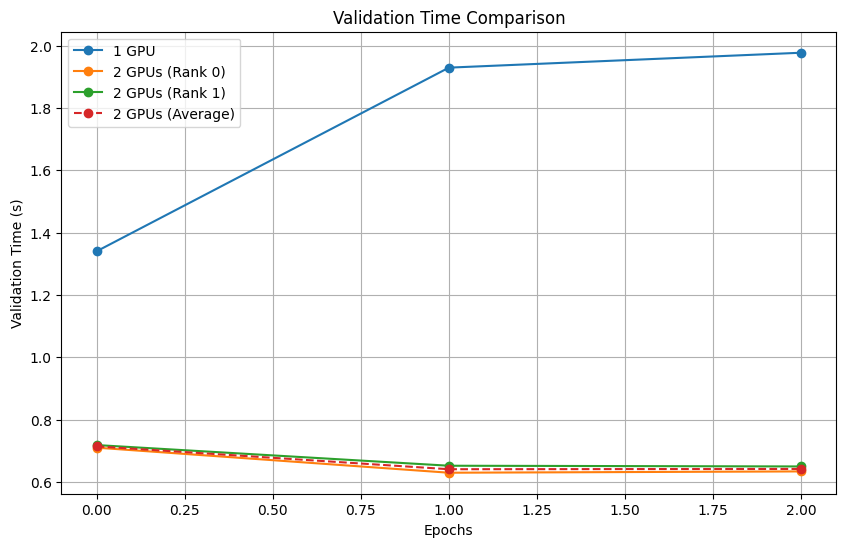

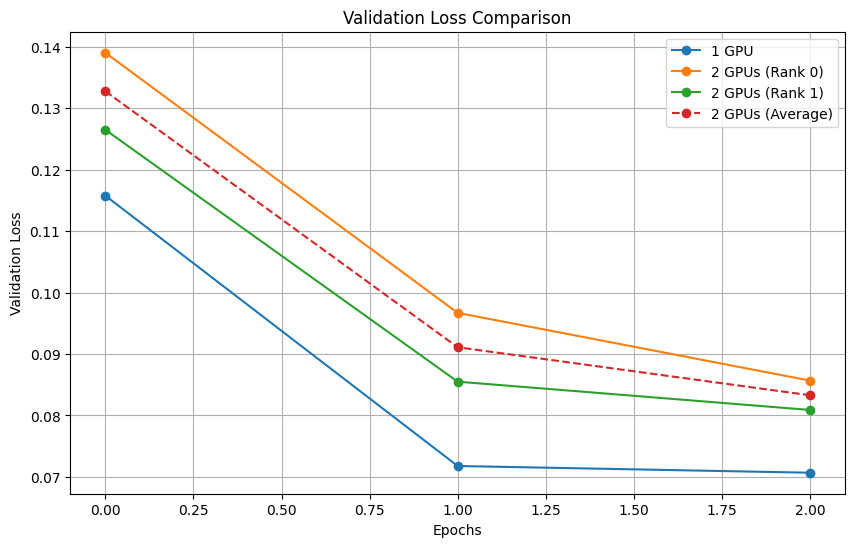

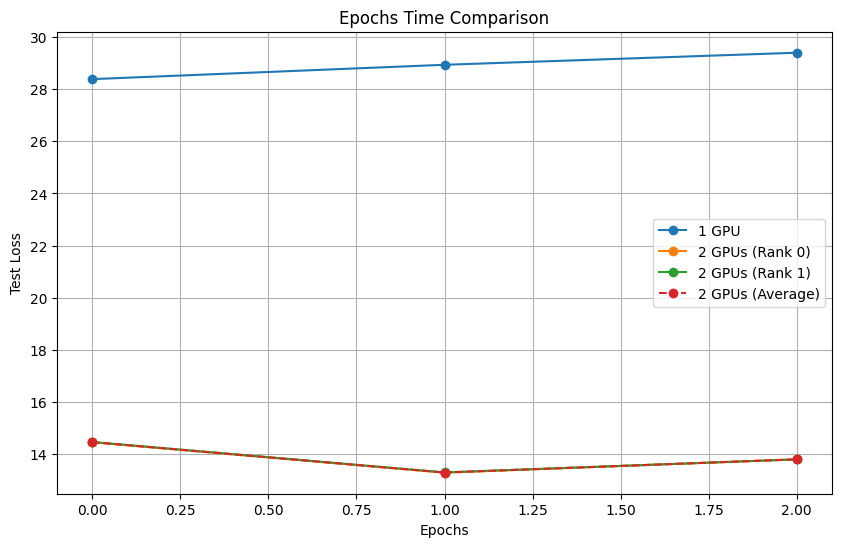

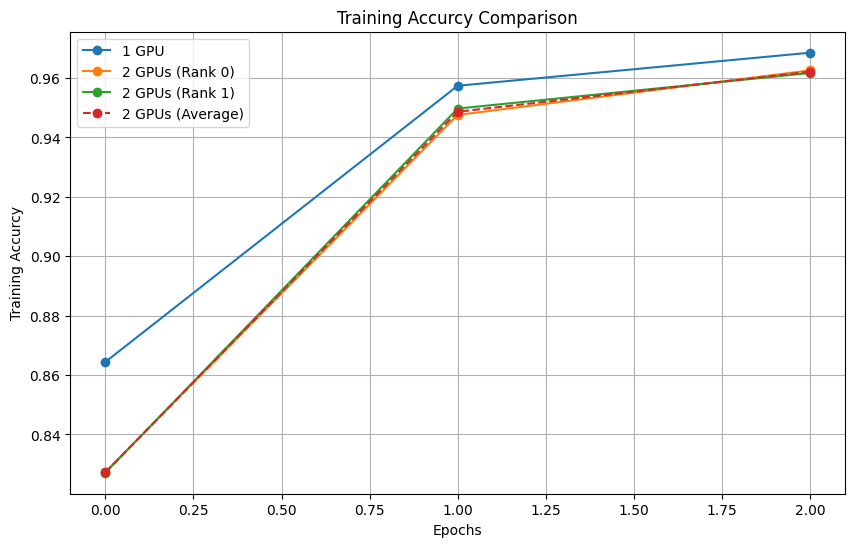

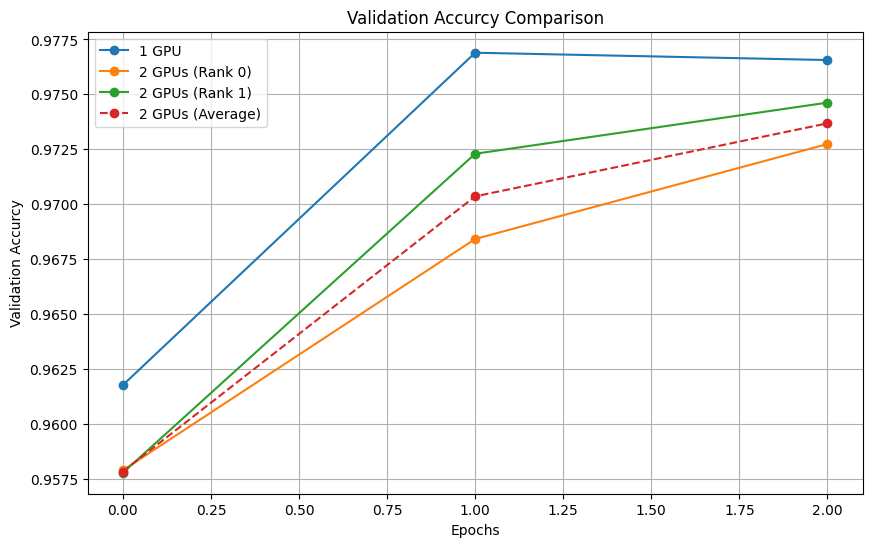

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics_seq2seq(json_file_1gpu, json_file_2gpus):
    """
    Generates plots comparing training metrics from 1-GPU and 2-GPU setups for a seq2seq model.
    Includes plots for rank 0, rank 1, and their average for the 2-GPU setup.
    """
    # Load 1-GPU data
    with open(json_file_1gpu, 'r') as f:
        data_1gpu = json.load(f)

    seq2seq_1gpu = data_1gpu[list(data_1gpu.keys())[0]]

    # Load 2-GPU data
    with open(json_file_2gpus, 'r') as f:
        data_2gpus = json.load(f)
    seq2seq_2gpus_rank0 = data_2gpus[list(data_2gpus.keys())[0]]
    seq2seq_2gpus_rank1 = data_2gpus[list(data_2gpus.keys())[1]]

    # Extract data for 1 GPU
    train_times_1gpu = seq2seq_1gpu['training_times']
    train_losses_1gpu = seq2seq_1gpu['train_losses']
    val_times_1gpu = seq2seq_1gpu['validation_times']
    val_losses_1gpu = seq2seq_1gpu['validation_losses']
    epoch_times_1gpu = seq2seq_1gpu['epoch_times']
    train_accuracy_1gpu = seq2seq_1gpu['train_accuracy']
    validation_accuracy_1gpu = seq2seq_1gpu['validation_accuracy']

    # Extract data for 2 GPUs (rank 0)
    train_times_2gpus_rank0 = seq2seq_2gpus_rank0['training_times']
    train_losses_2gpus_rank0 = seq2seq_2gpus_rank0['train_losses']
    val_times_2gpus_rank0 = seq2seq_2gpus_rank0['validation_times']
    val_losses_2gpus_rank0 = seq2seq_2gpus_rank0['validation_losses']
    epoch_times_2gpus_rank0 = seq2seq_2gpus_rank0['epoch_times']
    train_accuracy_2gpus_rank0 = seq2seq_2gpus_rank0['train_accuracy']
    validation_accuracy_2gpus_rank0 = seq2seq_2gpus_rank0['validation_accuracy']


    # Extract data for 2 GPUs (rank 1)
    train_times_2gpus_rank1 = seq2seq_2gpus_rank1['training_times']
    train_losses_2gpus_rank1 = seq2seq_2gpus_rank1['train_losses']
    val_times_2gpus_rank1 = seq2seq_2gpus_rank1['validation_times']
    val_losses_2gpus_rank1 = seq2seq_2gpus_rank1['validation_losses']
    epoch_times_2gpus_rank1 = seq2seq_2gpus_rank1['epoch_times']
    train_accuracy_2gpus_rank1 = seq2seq_2gpus_rank1['train_accuracy']
    validation_accuracy_2gpus_rank1 = seq2seq_2gpus_rank1['validation_accuracy']


    # Calculate averages for 2 GPUs
    train_times_2gpus_avg = np.mean([train_times_2gpus_rank0, train_times_2gpus_rank1], axis=0)
    train_losses_2gpus_avg = np.mean([train_losses_2gpus_rank0, train_losses_2gpus_rank1], axis=0)
    val_times_2gpus_avg = np.mean([val_times_2gpus_rank0, val_times_2gpus_rank1], axis=0)
    val_losses_2gpus_avg = np.mean([val_losses_2gpus_rank0, val_losses_2gpus_rank1], axis=0)
    epoch_times_2gpus_avg = np.mean([epoch_times_2gpus_rank0, epoch_times_2gpus_rank1], axis=0)
    train_accuracy_2gpus_avg = np.mean([train_accuracy_2gpus_rank0, train_accuracy_2gpus_rank1], axis=0)
    validation_accuracy_2gpus_avg = np.mean([validation_accuracy_2gpus_rank0, validation_accuracy_2gpus_rank1], axis=0)


    # Epochs for x-axis
    epochs = list(range(len(train_times_1gpu)))

    # Plot Training Times
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_times_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, train_times_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, train_times_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, train_times_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, train_losses_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, train_losses_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, train_losses_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Times
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_times_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, val_times_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, val_times_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, val_times_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Time (s)')
    plt.title('Validation Time Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_losses_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, val_losses_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, val_losses_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, val_losses_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Test Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_times_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, epoch_times_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, epoch_times_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, epoch_times_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Epochs Time Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Accurcy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, train_accuracy_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, train_accuracy_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, train_accuracy_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accurcy')
    plt.title('Training Accurcy Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accurcy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_accuracy_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, validation_accuracy_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, validation_accuracy_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, validation_accuracy_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accurcy')
    plt.title('Validation Accurcy Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Test Accurcy
    ''' plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_Accurcys_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, test_Accurcys_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, test_Accurcys_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, test_Accurcys_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accurcy')
    plt.title('Test Accurcy Comparison')
    plt.legend()
    plt.grid()
    plt.show()'''

if __name__ == "__main__":
    plot_training_metrics_seq2seq('/content/LeNet_10epochs_1GPU.json', '/content/LeNet_10epochs_2GPU.json')

In [ ]:
train_accuracy